# Time Series Prediction

In [8]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D, AveragePooling1D
from keras.callbacks import EarlyStopping
import json
import random
from keras import backend as K

## Read in Data

In [9]:
# Read in feature data
with open('../../../../data/feature_database.json') as json_database:
    database = json.load(json_database)
# Concat data
feature_data = None
for i in database:
    # Filter emission data
    if (database[i]['sector'] != 'target_values' and 
        database[i]['sector'] != 'greenhouse_emissions'):
        new_data = pd.read_json(database[i]['data'])
        if feature_data is None:
            feature_data = new_data
        else:
            feature_data = pd.concat([feature_data, new_data], axis=1, join="inner")
    else:
        print(f"Feature not used: {i}")
feature_data = feature_data.values
feature_data = feature_data.astype('float64')
print(f"Shape input features: {feature_data.shape}")
#feature_data.head()

Feature not used: E_Mio.tonnes_CO2
Feature not used: M_Mio.tonnes_CO2
Feature not used: ECO_Mio.tonnes_CO2
Feature not used: Total_CO2_Emission
Shape input features: (111, 40)


In [10]:
# Read in emission data
emission_data = pd.read_csv('../../../../data/greenhouse_emissions/oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv')
emission_data = emission_data['Total_CO2_Emission'].values
emission_data = emission_data.astype('float64')
# Take only the emissions on which we have indicators
emission_data = emission_data[len(emission_data)-feature_data.shape[0]:]
print(f"Shape output data: {emission_data.shape}")

Shape output data: (111,)


In [11]:
# Convert an array of values into a dataset matrix
def sliding_window(input, output, look_back=1, horizon=1, shuffle=False):
    dataX, dataY = [], []
    if len(input) != len(output):
        raise ValueError('Input and ouput do not have same length!')
    for i in range(len(input)-look_back-horizon):
        dataX.append(input[i:(i+look_back)])
        dataY.append(output[(i+look_back):(i+look_back+horizon)])
    # Shuffle windows
    if shuffle is True:
        dataX, dataY = shuffle(dataX, dataY, random_state=0)
    return np.array(dataX), np.array(dataY)

In [12]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [13]:
def plot_model_history(history, ax=None, metric='loss', ep_start=1, ep_stop=None, monitor='val_loss', mode='min', plttitle=None):
    if ax is None:
        fig,ax = plt.subplots()
    if ep_stop is None:
        ep_stop = len(history.epoch)
    if plttitle is None:
        plttitle = metric[0].swapcase() + metric[1:] + ' During Training'
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history[metric][ep_start-1:ep_stop])
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history['val_' + metric][ep_start-1:ep_stop])
    ax.set(title=plttitle)
    ax.set(ylabel=metric[0].swapcase() + metric[1:])
    ax.set(xlabel='Epoch')
    ax.legend(['train', 'val'], loc='upper right')

In [14]:
scaler = StandardScaler()
#scaler = MinMaxScaler()
feature_data = scaler.fit_transform(feature_data)

look_back = 12  # months
horizon = 12     # months
split_ratio = 0.75
shuffle = True

# Split into train and test sets
train_size = int(len(feature_data) * split_ratio)
test_size = len(feature_data) - train_size
if test_size < (look_back+horizon):
    raise ValueError('Split ratio too small. Increase test size!')

### Long Short-Term Memory

In [15]:
def train_lstm(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000, restore_best_weights=True)
    
    model = Sequential(name='LSTM')    
    model.add(InputLayer(input_shape=(look_back, trainX.shape[2])))
    model.add(LSTM(256, return_sequences=True, name="LSTM_1"))
    model.add(BatchNormalization())
    model.add(LSTM(128, return_sequences=True, name="LSTM_2"))
    model.add(BatchNormalization())
    #model.add(LSTM(96, return_sequences=True, name="LSTM_3"))
    #model.add(BatchNormalization())
    model.add(LSTM(64, return_sequences=False, name="LSTM_4"))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu', name="LSTM_Dense1"))
    #model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', name="LSTM_Dense2"))
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', name="LSTM_Dense3"))    
    model.add(Dense(horizon,activation="linear",name="LSTM_output"))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    model.summary()
    history = model.fit(trainX, trainY, validation_split=0.2, epochs=250, batch_size=8, verbose=1, callbacks=[es])
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=1)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(testX, testY, verbose=1)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict

### Convolutional Neural Network 

In [16]:
def train_cnn(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25, restore_best_weights=True)
    
    model = Sequential(name='CNN') 
    model.add(InputLayer(input_shape=(look_back, trainX.shape[2])))
    model.add(Conv1D(filters=128, kernel_size=5, activation='elu', name="Conv_1"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_1'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=3, activation='elu', name="Conv_2"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_2'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=2, activation='relu', name="Conv_3"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_3'))
    model.add(BatchNormalization())
    model.add(Flatten())    
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation='elu', name='Dense_1'))
    #model.add(Dense(8, activation='elu', name='Dense_2'))
    model.add(Dense(horizon, activation='linear', name="CNN_output"))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    model.summary()
    model.fit(trainX, trainY, validation_split=0.2, epochs=250, batch_size=8, verbose=1, callbacks=[es])
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(testX, testY, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict

In [17]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, InputLayer, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D, GlobalAveragePooling1D


def train_wavenet(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000, restore_best_weights=True)
    
    # convolutional operation parameters
    n_filters = 32 # 32 
    filter_width = 2
    dilation_rates = [2**i for i in range(4)] * 2 

    # define an input history series and pass it through a stack of dilated causal convolution blocks. 
    history_seq = Input(shape=(look_back, trainX.shape[2]))
    x = history_seq

    skips = []
    for dilation_rate in dilation_rates:

        # preprocessing - equivalent to time-distributed dense
        x = Conv1D(16, 1, padding='same', activation='relu')(x) 

        # filter convolution
        x_f = Conv1D(filters=n_filters,
                     kernel_size=filter_width, 
                     padding='causal',
                     dilation_rate=dilation_rate)(x)

        # gating convolution
        x_g = Conv1D(filters=n_filters,
                     kernel_size=filter_width, 
                     padding='causal',
                     dilation_rate=dilation_rate)(x)

        # multiply filter and gating branches
        z = Multiply()([Activation('tanh')(x_f),
                        Activation('sigmoid')(x_g)])

        # postprocessing - equivalent to time-distributed dense
        z = Conv1D(16, 1, padding='same', activation='relu')(z)

        # residual connection
        x = Add()([x, z])    

        # collect skip connections
        skips.append(z)

    # add all skip connection outputs 
    out = Activation('elu')(Add()(skips))

    # final time-distributed dense layers 
    out = Conv1D(128, 1, padding='same')(out)
    out = Activation('relu')(out)
    #out = Dropout(.2)(out)
    #out = Conv1D(1, 1, padding='same')(out)
    out = AveragePooling1D(2)(out)
    out = GlobalMaxPooling1D()(out)
    #out = GlobalAveragePooling1D(out)
    out = Dense(horizon, activation='linear', name="final_dense_layer")(out)

    model = Model(history_seq, out)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    model.summary()
    history = model.fit(trainX, trainY, validation_split=0.2, epochs=250, batch_size=4, verbose=1, callbacks=[es])
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=1)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(testX, testY, verbose=1)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict, history

In [18]:
# Features as input
trainX, trainY = sliding_window(feature_data[0:train_size,:],
                                emission_data[0:train_size],
                                look_back,
                                horizon)
testX, testY = sliding_window(feature_data[train_size:len(feature_data),:],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

In [19]:
print("Shape of data:")
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

Shape of data:
(59, 12, 40)
(59, 12)
(4, 12, 40)
(4, 12)


### Train Model

In [20]:
#Varying number of features

num_of_feats = 20
random_list = []

for i in range(num_of_feats):
        value = random.randint(0, 39)
        
        while value in random_list:
            value = random.randint(0, 39)
            
        random_list.append(value)        
        
random_list

[7, 8, 16, 32, 11, 35, 13, 33, 10, 9, 36, 1, 3, 28, 39, 37, 22, 12, 26, 0, 18]

In [21]:
#trainX = trainX[:, :, random_list]
print(trainX.shape)
#testX = testX[:, :, random_list]
print(testX.shape)

(59, 12, 40)
(4, 12, 40)


In [22]:
# Create and fit Multilayer Perceptron model for every indicator
trainPredictPlot = np.empty_like(emission_data)
trainPredictPlot[:] = np.nan
testPredictPlot = np.empty_like(emission_data)
testPredictPlot[:] = np.nan



# Train model and generate predictions
model, trainPredict, testPredict, history = train_wavenet(trainX, trainY, testX, testY,
                                               look_back, horizon)

# Shift train predictions for plotting
for t in range(len(trainPredict)):
    trainPredictPlot[t+look_back:t+look_back+horizon] = trainPredict[t, :]
for t in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+t+look_back+horizon:len(trainPredict)+
                    t+look_back+(horizon*2)] = testPredict[t, :]

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12, 40)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 12, 16)       656         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 12, 32)       1056        conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 12, 32)       1056        conv1d_1[0][0]                   
____________________________________________________________________________________________

Train on 47 samples, validate on 12 samples
Epoch 1/250
47/47 [==============================] - 3s 59ms/step - loss: 4750.6537 - r2_keras: -181.1287 - val_loss: 4584.1068 - val_r2_keras: -204.7870
Epoch 2/250
47/47 [==============================] - 0s 5ms/step - loss: 4427.3690 - r2_keras: -168.9657 - val_loss: 3898.5120 - val_r2_keras: -174.0318
Epoch 3/250
47/47 [==============================] - 0s 5ms/step - loss: 3075.1924 - r2_keras: -117.0801 - val_loss: 1871.9882 - val_r2_keras: -83.0393
Epoch 4/250
47/47 [==============================] - 0s 5ms/step - loss: 886.7063 - r2_keras: -32.6300 - val_loss: 187.1667 - val_r2_keras: -7.3765
Epoch 5/250
47/47 [==============================] - 0s 6ms/step - loss: 178.1021 - r2_keras: -5.8180 - val_loss: 58.5810 - val_r2_keras: -1.6129
Epoch 6/250
47/47 [==============================] - 0s 5ms/step - loss: 45.9930 - r2_keras: -0.7523 - val_loss: 56.3776 - val_r2_keras: -1.5423
Epoch 7/250
47/47 [==============================] - 0s 5m

47/47 [==============================] - 0s 5ms/step - loss: 10.6063 - r2_keras: 0.5907 - val_loss: 9.1055 - val_r2_keras: 0.5925
Epoch 58/250
47/47 [==============================] - 0s 5ms/step - loss: 9.4966 - r2_keras: 0.6360 - val_loss: 8.6078 - val_r2_keras: 0.6165
Epoch 59/250
47/47 [==============================] - 0s 6ms/step - loss: 8.7973 - r2_keras: 0.6639 - val_loss: 8.3916 - val_r2_keras: 0.6268
Epoch 60/250
47/47 [==============================] - 0s 5ms/step - loss: 7.8044 - r2_keras: 0.6995 - val_loss: 7.9399 - val_r2_keras: 0.6456
Epoch 61/250
47/47 [==============================] - 0s 5ms/step - loss: 6.5907 - r2_keras: 0.7483 - val_loss: 6.6246 - val_r2_keras: 0.7042
Epoch 62/250
47/47 [==============================] - 0s 6ms/step - loss: 5.6844 - r2_keras: 0.7817 - val_loss: 5.4886 - val_r2_keras: 0.7548
Epoch 63/250
47/47 [==============================] - 0s 6ms/step - loss: 5.2056 - r2_keras: 0.7996 - val_loss: 5.9685 - val_r2_keras: 0.7323
Epoch 64/250
47/47

Epoch 115/250
47/47 [==============================] - 0s 7ms/step - loss: 0.7498 - r2_keras: 0.9712 - val_loss: 1.1916 - val_r2_keras: 0.9477
Epoch 116/250
47/47 [==============================] - 0s 6ms/step - loss: 0.7301 - r2_keras: 0.9720 - val_loss: 1.3135 - val_r2_keras: 0.9423
Epoch 117/250
47/47 [==============================] - 0s 6ms/step - loss: 0.7145 - r2_keras: 0.9729 - val_loss: 1.2827 - val_r2_keras: 0.9437
Epoch 118/250
47/47 [==============================] - 0s 5ms/step - loss: 0.7339 - r2_keras: 0.9715 - val_loss: 1.3425 - val_r2_keras: 0.9411
Epoch 119/250
47/47 [==============================] - 0s 5ms/step - loss: 0.7434 - r2_keras: 0.9714 - val_loss: 1.5542 - val_r2_keras: 0.9318
Epoch 120/250
47/47 [==============================] - 0s 5ms/step - loss: 0.7538 - r2_keras: 0.9712 - val_loss: 1.4687 - val_r2_keras: 0.9354
Epoch 121/250
47/47 [==============================] - 0s 5ms/step - loss: 0.6973 - r2_keras: 0.9732 - val_loss: 1.4267 - val_r2_keras: 0.9372

47/47 [==============================] - 0s 5ms/step - loss: 0.4686 - r2_keras: 0.9822 - val_loss: 1.1544 - val_r2_keras: 0.9491
Epoch 173/250
47/47 [==============================] - 0s 5ms/step - loss: 0.4541 - r2_keras: 0.9828 - val_loss: 1.2257 - val_r2_keras: 0.9461
Epoch 174/250
47/47 [==============================] - 0s 5ms/step - loss: 0.4843 - r2_keras: 0.9815 - val_loss: 1.1359 - val_r2_keras: 0.9500
Epoch 175/250
47/47 [==============================] - 0s 5ms/step - loss: 0.4333 - r2_keras: 0.9835 - val_loss: 1.1120 - val_r2_keras: 0.9510
Epoch 176/250
47/47 [==============================] - 0s 5ms/step - loss: 0.4378 - r2_keras: 0.9833 - val_loss: 1.1239 - val_r2_keras: 0.9507
Epoch 177/250
47/47 [==============================] - 0s 5ms/step - loss: 0.4329 - r2_keras: 0.9837 - val_loss: 1.1351 - val_r2_keras: 0.9501
Epoch 178/250
47/47 [==============================] - 0s 5ms/step - loss: 0.4228 - r2_keras: 0.9840 - val_loss: 1.1108 - val_r2_keras: 0.9512
Epoch 179/250

47/47 [==============================] - 0s 5ms/step - loss: 0.3241 - r2_keras: 0.9875 - val_loss: 1.2038 - val_r2_keras: 0.9473
Epoch 230/250
47/47 [==============================] - 0s 5ms/step - loss: 0.2877 - r2_keras: 0.9889 - val_loss: 1.1223 - val_r2_keras: 0.9506
Epoch 231/250
47/47 [==============================] - 0s 5ms/step - loss: 0.3053 - r2_keras: 0.9883 - val_loss: 1.2227 - val_r2_keras: 0.9463
Epoch 232/250
47/47 [==============================] - 0s 5ms/step - loss: 0.2948 - r2_keras: 0.9887 - val_loss: 1.0690 - val_r2_keras: 0.9531
Epoch 233/250
47/47 [==============================] - 0s 5ms/step - loss: 0.3025 - r2_keras: 0.9885 - val_loss: 1.2647 - val_r2_keras: 0.9444
Epoch 234/250
47/47 [==============================] - 0s 5ms/step - loss: 0.2843 - r2_keras: 0.9889 - val_loss: 1.0364 - val_r2_keras: 0.9545
Epoch 235/250
47/47 [==============================] - 0s 5ms/step - loss: 0.2865 - r2_keras: 0.9891 - val_loss: 1.2426 - val_r2_keras: 0.9454
Epoch 236/250

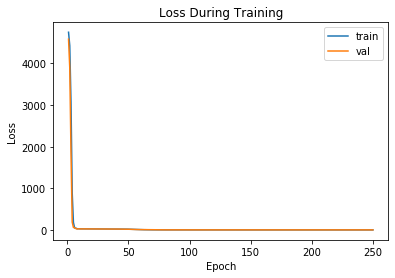

In [23]:
plot_model_history(history)

### Prediction and Plot

Forecast: [[67.56274  65.08459  62.96061  60.212303 57.51213  55.287636 54.975643
  58.445297 61.293873 62.69139  65.131744 66.67646 ]]


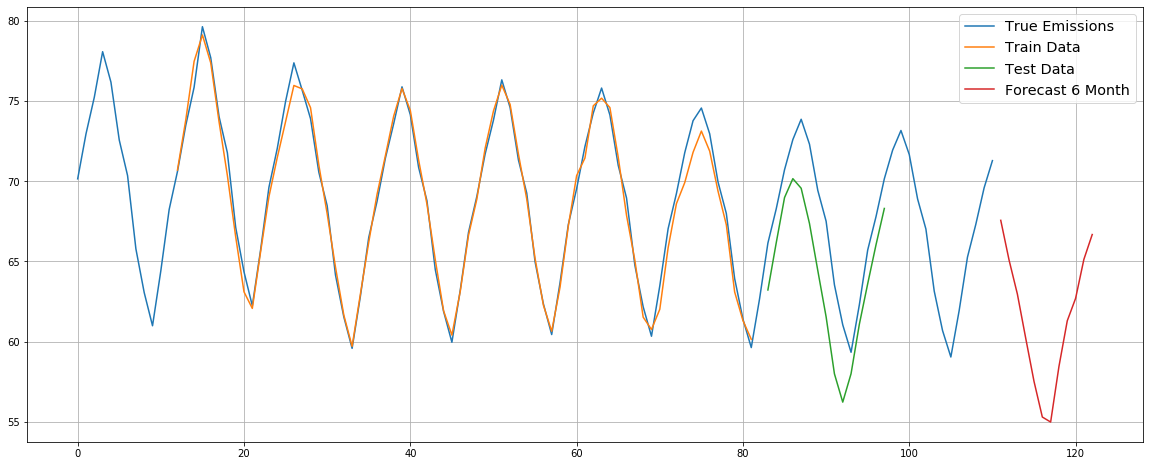

In [24]:
# Forecast predictions
forecastPlot = np.zeros((len(emission_data) + horizon))
forecastPlot[:] = np.nan

# Features
#X = np.zeros((1, look_back, feature_data.shape[1]))
X = np.zeros((1, look_back, trainX.shape[2]))
#X[0] = feature_data[len(feature_data)-look_back:, :]
X[0] = feature_data[len(feature_data)-look_back:, :trainX.shape[2]]
predict = model.predict(X)
forecastPlot[len(feature_data):len(feature_data)+horizon] = predict[:]

print(f"Forecast: {predict}")

# Plot baseline, training, test and forecast
plt.figure(figsize=(20,8))
line1 = plt.plot(emission_data[:], label='True Emissions')
line2 = plt.plot(trainPredictPlot[:], label='Train Data')
plt.plot(testPredictPlot[:], label='Test Data')
plt.plot(forecastPlot[:], label='Forecast 6 Month')
plt.legend(fontsize='x-large')
plt.grid()
plt.xticks()
plt.show()